# Word Sense Disambiguation (WSD) of Word-in-Context (WiC) data

Third homework of the Natural Language Processing course 2021 @ Sapienza University of Rome.

Prof. Roberto Navigli

MSc in Computer Science

**Author**: Andrea Gasparini - 1813486

In [1]:
import os
import random

import wandb
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from stud import constants, utils
from stud.data import HParams, Pos, Token
from stud.datasets import WSDDataset, GlossBERTDataset
from stud.sense_inventories import build_senses_vocab, SenseInventory
from stud.data_readers import read_wic_corpus, read_wsd_gold_keys, read_wsd_corpus
from stud.pl_data_modules import WSDDataModule, GlossBERTDataModule
from stud.transformer_embedder import TransformerEmbedder
from stud.pl_modules import WordSenseDisambiguator, GlossBERT

In [2]:
pl.seed_everything(42, workers=True)

Global seed set to 42


42

## Preprocessing

### WSDisambiguator datasets

In [18]:
training_corpus = read_wsd_corpus(f"{constants.TRAIN_SET_PATH.replace('../..', '..')}{constants.XML_DATA_SUFFIX.replace('../..', '..')}",
									f"{constants.TRAIN_SET_PATH.replace('../..', '..')}{constants.TXT_GOLD_KEYS_SUFFIX.replace('../..', '..')}")
semeval2007_corpus = read_wsd_corpus(f"{constants.VALID_SET_PATH.replace('../..', '..')}{constants.XML_DATA_SUFFIX.replace('../..', '..')}",
				         			 f"{constants.VALID_SET_PATH.replace('../..', '..')}{constants.TXT_GOLD_KEYS_SUFFIX.replace('../..', '..')}")
evaluation_corpus = read_wsd_corpus(f"{constants.TEST_SET_PATH.replace('../..', '..')}{constants.XML_DATA_SUFFIX.replace('../..', '..')}",
									f"{constants.TEST_SET_PATH.replace('../..', '..')}{constants.TXT_GOLD_KEYS_SUFFIX.replace('../..', '..')}")

wic_samples_dev = read_wic_corpus(constants.WIC_TEST_SET_PATH.replace('../..', '..'), constants.WIC_TEST_SET_WSD_KEYS_PATH.replace('../..', '..'))
wic_corpus_dev = list()
for wic_sample in wic_samples_dev:
	wic_corpus_dev.append(wic_sample.sentence1)
	wic_corpus_dev.append(wic_sample.sentence2)

wic_samples_train = read_wic_corpus(constants.WIC_TRAIN_SET_PATH.replace('../..', '..'))
wic_corpus_train = list()
for wic_sample in wic_samples_train:
	wic_corpus_train.append(wic_sample.sentence1)
	wic_corpus_train.append(wic_sample.sentence2)

sense_invent = SenseInventory(constants.GLOSSES_PATH.replace('../..', '..'), constants.LEMMA_POS_DICT_PATH.replace('../..', '..'))
senses_vocabulary = build_senses_vocab(training_corpus + evaluation_corpus + wic_corpus_dev)

embedder_model = utils.get_pretrained_model(constants.TRANSFORMER_EMBEDDER_PATH.replace('../..', '..'))

train_set = WSDDataset(training_corpus, embedder_model, sense_invent, senses_vocabulary)
torch.save(train_set, constants.PREPROCESSED_TRAIN_PATH.replace('../..', '..'))

valid_set = WSDDataset(semeval2007_corpus, embedder_model, sense_invent, senses_vocabulary)
torch.save(valid_set, constants.PREPROCESSED_VALID_PATH.replace('../..', '..'))

test_set = WSDDataset(wic_corpus_dev, embedder_model, sense_invent, senses_vocabulary)
torch.save(test_set, constants.PREPROCESSED_TEST_PATH.replace('../..', '..'))

100%|██████████| 1802/1802 [00:19<00:00, 92.70it/s]


### GlossBERT datasets

In [5]:
training_corpus = read_wsd_corpus(f"{constants.TRAIN_SET_PATH.replace('../..', '..')}{constants.XML_DATA_SUFFIX.replace('../..', '..')}",
								  f"{constants.TRAIN_SET_PATH.replace('../..', '..')}{constants.TXT_GOLD_KEYS_SUFFIX.replace('../..', '..')}")
semeval2007_corpus = read_wsd_corpus(f"{constants.VALID_SET_PATH.replace('../..', '..')}{constants.XML_DATA_SUFFIX.replace('../..', '..')}",
				         			 f"{constants.VALID_SET_PATH.replace('../..', '..')}{constants.TXT_GOLD_KEYS_SUFFIX.replace('../..', '..')}")
evaluation_corpus = read_wsd_corpus(f"{constants.TEST_SET_PATH.replace('../..', '..')}{constants.XML_DATA_SUFFIX.replace('../..', '..')}",
									f"{constants.TEST_SET_PATH.replace('../..', '..')}{constants.TXT_GOLD_KEYS_SUFFIX.replace('../..', '..')}")

wic_samples_dev = read_wic_corpus(constants.WIC_TEST_SET_PATH.replace('../..', '..'), constants.WIC_TEST_SET_WSD_KEYS_PATH.replace('../..', '..'))
wic_corpus_dev = list()
for wic_sample in wic_samples_dev:
	wic_corpus_dev.append(wic_sample.sentence1)
	wic_corpus_dev.append(wic_sample.sentence2)

sense_invent = SenseInventory(constants.GLOSSES_PATH.replace('../..', '..'), constants.LEMMA_POS_DICT_PATH.replace('../..', '..'))

SemCor_fraction_size = 0.5
SemCor_fraction = random.sample(training_corpus, int(len(training_corpus) * SemCor_fraction_size))

train_set = GlossBERTDataset.from_tokens(SemCor_fraction, sense_invent)
train_set.save_as_json(f"../data/preprocessed/GlossBERT/SemCor{int(SemCor_fraction_size * 100)}.json")

valid_set = GlossBERTDataset.from_tokens(semeval2007_corpus, sense_invent)
valid_set.save_as_json(constants.PREPROCESSED_GLOSSBERT_VALID_PATH.replace('../..', '..'), indent=4)

test_set = GlossBERTDataset.from_tokens(wic_corpus_dev, sense_invent)
test_set.save_as_json(constants.PREPROCESSED_GLOSSBERT_TEST_PATH.replace('../..', '..'), indent=4)

100%|██████████| 18149/18149 [00:39<00:00, 456.75it/s]


## Training

### WSDisambiguator

In [ ]:
pl.seed_everything(42, workers=True)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

utils.nltk_downloads()

sense_inventory = SenseInventory(constants.GLOSSES_PATH.replace("../..", ".."), constants.LEMMA_POS_DICT_PATH.replace("../..", ".."))

data_module = WSDDataModule(constants.PREPROCESSED_TRAIN_PATH.replace("../..", ".."),
							constants.PREPROCESSED_VALID_PATH.replace("../..", ".."),
							constants.PREPROCESSED_TEST_PATH.replace("../..", ".."),
                            utils.get_pretrained_model(constants.TRANSFORMER_EMBEDDER_PATH.replace("../..", "..")),
							sense_inventory,
							torch.load("../model/vocabularies/senses_vocabulary_train.pt"),
							batch_size=16,
							num_workers=4,
							pin_memory=True)

hparams = HParams(num_classes=len(data_module.senses_vocab),
                  input_size=constants.TRANSFORMER_EMBEDDER_DIMENSION,
                  batch_size=data_module.batch_size)

MODELS_DIR = "../model/"
MODEL_NAME = "WSDisambiguator"

early_stopping = pl.callbacks.EarlyStopping(monitor="valid_wsd_accuracy",
                                            patience=5,
                                            verbose=True,
                                            mode="max")

check_point_callback = pl.callbacks.ModelCheckpoint(monitor="valid_wsd_accuracy",
                                                    verbose=True,
                                                    save_top_k=2,
                                                    save_last=False,
                                                    mode="max",
                                                    dirpath=MODELS_DIR,
                                                    filename=MODEL_NAME + "-{epoch}-{valid_wsd_loss:.4f}-"
                                                                          "{valid_wsd_f1:.3f}-{valid_wsd_accuracy:.3f}")

wandb_logger = WandbLogger(offline=False, project="nlp_hw3", name=MODEL_NAME)

trainer = pl.Trainer(
    gpus=1 if torch.cuda.is_available() else 0,
    logger=wandb_logger,
    val_check_interval=1.0,
    max_epochs=100,
    callbacks=[early_stopping, check_point_callback],
    deterministic=True
)

model = WordSenseDisambiguator(hparams.as_dict(), data_module.senses_vocab, data_module.senses_vocab[constants.UNK_TOKEN])

trainer.fit(model, datamodule=data_module)

wandb.finish()

Global seed set to 42
[nltk_data] Downloading package wordnet to /home/andrea/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: andreagasparini. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/home/andrea/miniconda3/envs/nlp2021-hw3/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /home/andrea/Projects/uni/magistrale/natural-language-processing/nlp2021-hw3/model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | senses_vocab  | Vocab            | 0     
1 | model         | Sequential       | 15.8 M
2 | loss_function | CrossEntropyLoss | 0     
3 | train_acc     | Accuracy         | 0     
4 | train_f1      | F1Score          | 0     
5 | valid_acc     | Accuracy        

Sanity Checking: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/andrea/miniconda3/envs/nlp2021-hw3/lib/python3.7/site-packages/pytorch_lightning/utilities/data.py:73: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Training: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

### GlossBERT

In [3]:
pl.seed_everything(42, workers=True)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

utils.nltk_downloads()

sense_inventory = SenseInventory(constants.GLOSSES_PATH.replace('../..', '..'), constants.LEMMA_POS_DICT_PATH.replace('../..', '..'))

data_module = GlossBERTDataModule(constants.PREPROCESSED_GLOSSBERT_TRAIN_PATH.replace("../..", ".."),
							      constants.PREPROCESSED_GLOSSBERT_VALID_PATH.replace("../..", ".."),
							      constants.PREPROCESSED_GLOSSBERT_TEST_PATH.replace("../..", ".."),
							      batch_size=8,
							      num_workers=4,
							      pin_memory=True)

hparams = HParams(num_classes=1, learning_rate=2e-5, batch_size=data_module.batch_size, input_size=None)

MODELS_DIR = "../model/"
MODEL_NAME = "GlossBERT"

early_stopping = pl.callbacks.EarlyStopping(monitor="valid_wsd_accuracy",
                                            patience=5,
                                            verbose=True,
                                            mode="max")

check_point_callback = pl.callbacks.ModelCheckpoint(monitor="valid_wsd_accuracy",
                                                    verbose=True,
                                                    save_top_k=4,
                                                    save_last=False,
                                                    mode="max",
                                                    dirpath=MODELS_DIR,
                                                    filename=MODEL_NAME + "-{epoch}-{valid_wsd_loss:.4f}-"
                                                                          "{valid_wsd_f1:.3f}-{valid_wsd_accuracy:.3f}")

wandb_logger = WandbLogger(offline=False, project="nlp_hw3", name=MODEL_NAME)

trainer = pl.Trainer(
    gpus=1 if torch.cuda.is_available() else 0,
    logger=wandb_logger,
    val_check_interval=1.0,
    max_epochs=10,
    callbacks=[early_stopping, check_point_callback],
    deterministic=True
)

model = GlossBERT(hparams.as_dict(), constants.TRANSFORMER_EMBEDDER_PATH.replace('../..', '..'))

trainer.fit(model, datamodule=data_module)

wandb.finish()

Global seed set to 42
[nltk_data] Downloading package wordnet to /home/andrea/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
wandb: Currently logged in as: andreagasparini. Use `wandb login --relogin` to force relogin


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/andrea/minico

Sanity Checking: 0it [00:00, ?it/s]

/home/andrea/miniconda3/envs/nlp2021-hw3/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/home/andrea/miniconda3/envs/nlp2021-hw3/lib/python3.7/site-packages/pytorch_lightning/utilities/data.py:73: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
/home/andrea/miniconda3/envs/nlp2021-hw3/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not h

Training: 0it [00:00, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 86.00 MiB (GPU 0; 1.95 GiB total capacity; 998.02 MiB already allocated; 80.31 MiB free; 1.07 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Testing

In [3]:
mode = "GlossBERT" # "WSDisambiguator" | "GlossBERT"

In [72]:
bert_model_name = utils.get_pretrained_model(constants.TRANSFORMER_EMBEDDER_PATH)

if mode == "WSDisambiguator":
    vocab = torch.load("../model/vocabularies/senses_vocabulary_train.pt")
    wic_dataset = WSDDataset.from_preprocessed(constants.PREPROCESSED_TEST_PATH.replace('../..', '..'))
    wic_dataset.to_device(model.device)
else:
    vocab = torch.load("../model/vocabularies/senses_vocabulary_full.pt")
    # wic_dataset = GlossBERTDataset.from_json(constants.PREPROCESSED_GLOSSBERT_VALID_PATH.replace('../..', '..'))
    wic_dataset = GlossBERTDataset.from_json(constants.PREPROCESSED_GLOSSBERT_TEST_PATH.replace('../..', '..'))
    # wic_dataset = GlossBERTDataset.from_json("../data/preprocessed/GlossBERT/wic_dev_no_pos.json")

vocab_itos = vocab.get_itos()

In [73]:
if mode == "WSDisambiguator":
    MODEL_PATH = "../model/WSDisambiguator.ckpt"
    model = WordSenseDisambiguator.load_from_checkpoint(MODEL_PATH, senses_vocab=vocab)
else:
    MODEL_PATH = "../model/GlossBERT.ckpt"
    model = GlossBERT.load_from_checkpoint(MODEL_PATH, bert_model_name_or_path="../model/bert-base-cased")

In [74]:
model.freeze()
predictions = list()
predictions_indices = list()

if mode == "WSDisambiguator":
    progress_bar = tqdm(total=len(wic_dataset), desc='Evaluating')
    for batch in DataLoader(wic_dataset, batch_size=8, collate_fn=WSDDataset.collate_fn):
        out = model(batch)
        predicted_indices, predicted_ids = model.predict(batch, out)
        predictions += predicted_ids
        predictions_indices += predicted_indices
        progress_bar.update(len(batch))
else:
    tokens = list()
    probs = list()
    sense_indices = list()

    progress_bar = tqdm(total=len(wic_dataset), desc='Evaluating')

    dataloader = DataLoader(wic_dataset, batch_size=8, collate_fn=GlossBERTDataset.collate_fn)

    for batch in dataloader:
        out = model(batch)
        for i in range(len(batch["tokens"])):
            token = batch["tokens"][i]
            prob = out["probabilities"][i]
            sense_index = batch["sense_indices"][i]
            if len(tokens) > 0 and token == tokens[-1][-1]:
                tokens[-1].append(token)
                probs[-1] = torch.cat((probs[-1], torch.tensor([prob])))
                sense_indices[-1] = torch.cat((sense_indices[-1], torch.tensor([sense_index])))
            else:
                tokens.append([token])
                probs.append(torch.tensor([prob]))
                sense_indices.append(torch.tensor([sense_index]))

            progress_bar.update(1)

    for i in range(len(probs)):
        sample_prediction_index = torch.argmax(probs[i])
        predictions_indices.append(sense_indices[i][sample_prediction_index])
        predictions.append(vocab_itos[predictions_indices[i]])


Evaluating: 100%|██████████| 3861/3861 [19:35<00:00,  3.29it/s]

Evaluating: 100%|█████████▉| 8617/8622 [15:53<00:01,  4.03it/s]

In [75]:
predictions_indices = torch.stack(predictions_indices)
predictions[:10]

['superior%1:18:02::',
 'superior%1:18:02::',
 'superior%1:18:02::',
 'superior%1:18:01::',
 'acquaintance%1:09:00::',
 'acquaintance%1:09:00::',
 'acquaintance%1:09:00::',
 'acquaintance%1:18:00::',
 'baggage%1:06:00::',
 'baggage%1:06:00::']

In [76]:
if mode == "WSDisambiguator":
    gold = [vocab_itos[x["sense_index"]] for x in wic_dataset]
    gold_indices = torch.tensor([x["sense_index"] for x in wic_dataset])
else:
    # wsd_gold_keys_path = constants.VALID_SET_PATH.replace("../..", "..") + constants.TXT_GOLD_KEYS_SUFFIX
    wsd_gold_keys_path = constants.WIC_TEST_SET_WSD_KEYS_PATH.replace("../..", "..")
    gold = list(read_wsd_gold_keys(wsd_gold_keys_path).values())
    gold_indices = torch.tensor([vocab[x] for x in gold])
gold[:10]

['superior%1:18:01::',
 'superior%1:18:02::',
 'superior%1:18:01::',
 'superior%1:18:01::',
 'acquaintance%1:09:00::',
 'acquaintance%1:18:00::',
 'acquaintance%1:09:00::',
 'acquaintance%1:18:00::',
 'baggage%1:06:00::',
 'baggage%1:06:00::']

In [77]:
wsd_acc = accuracy_score(predictions, gold)
f"{wsd_acc:.4f}"

'0.6010'

In [78]:
wic_samples = read_wic_corpus(constants.WIC_TEST_SET_PATH.replace('../..', '..'), constants.WIC_TEST_SET_WSD_KEYS_PATH.replace('../..', '..'))
gold_wic = [x.sense1.sense_id == x.sense2.sense_id for x in wic_samples]

predictions_wic = [predictions[i] == predictions[i+1] for i in range(0, len(predictions), 2)]

In [79]:
wic_acc = accuracy_score(predictions_wic, gold_wic)
f"{wic_acc:.4f}"

'0.6804'

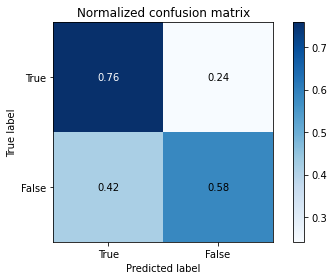

In [177]:
_, _ = utils.plot_confusion_matrix(gold_wic, predictions_wic, normalize=True)